In [33]:
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [81]:
## download and preparing data

def setup_seed(seed):
     torch.manual_seed(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(0)

BATCH_SIZE = 1024 # 大概需要2G的显存
EPOCHS = 20 # 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# 下载训练集
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train = True,download=True,transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Pad(1)
    ])),
    batch_size = BATCH_SIZE, shuffle = True)

# 测试集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train = False, transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Pad(1),
    ])),
    batch_size = BATCH_SIZE, shuffle = True)


examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets[0:9])
print(example_data.shape)

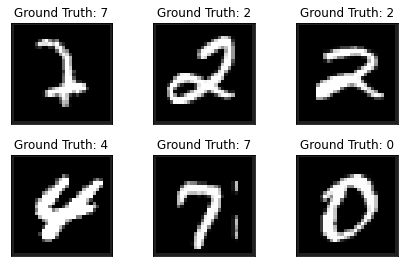

In [63]:
## viz sample data
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()


import matplotlib.pyplot as plt
plt.imshow(example_data[1][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[1]))
plt.xticks([])
plt.yticks([])
plt.show()

In [213]:
## decompose data and targets
## divide mat
def divide_mat(img_mat,img_size):
    img_mat[img_mat>0] = 1
    mat_num = np.array(img_mat).shape[0]/img_size
    ## error handling
    if mat_num//1 != mat_num:
        print("wrong img_size")
        return 0
    ## create tmp variable
    mat_num = int(mat_num)
    tmp_ndarray = np.zeros([mat_num*mat_num,img_size,img_size])
    tmp_targets = np.zeros(mat_num*mat_num)
    ## divide mat
    k = 0
    for i in range(mat_num):
        tmp_array = np.array_split(img_mat,mat_num)
        for j in range(mat_num):
            tmp_ndarray[k,:,:] = np.hsplit(tmp_array[i],mat_num)[j]
            k = k + 1
            
    for idx in range(k):
        if tmp_ndarray[idx].sum()/(img_size*img_size)>0.3:
            tmp_targets[idx] = 1
            
    return tmp_ndarray,tmp_targets
    
img_size = 10
data_set,tag_set = divide_mat(example_data[1][0],img_size)
for i in range(BATCH_SIZE):
    tmp_data,tmp_tag = divide_mat(example_data[i][0],img_size)
    data_set = np.concatenate((data_set,tmp_data))
    tag_set = np.concatenate((tag_set,tmp_tag))
    
print(data_set.shape)
print(tag_set.shape)

## futher data process
#np.random.uniform(low=0.0, high=1.0)

(9225, 10, 10)
(9225,)


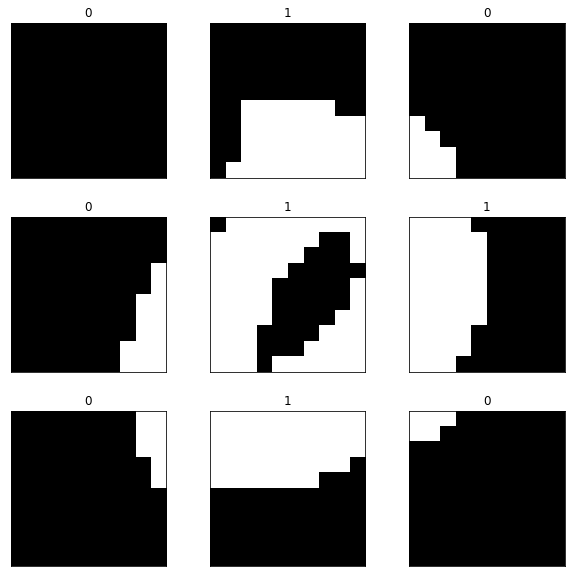

In [214]:
## viz generated data
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(tmp_data[i], cmap='gray', interpolation='none')
  plt.title("{}".format(int(tmp_tag[i])))
  plt.xticks([])
  plt.yticks([])
plt.subplots_adjust(wspace =0.25, hspace =0.25)
plt.show()

# build the NN

In [306]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, 5, 1)
        self.max_pool = nn.MaxPool2d(2,1)
        self.conv2 = nn.Conv2d(40, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 12, 3, 1)
        self.fc = nn.Linear(12, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.sigmoid(x)
        return output

model = Net().to(DEVICE)

# make a dataloader

In [253]:
from torch.utils.data import Dataset, DataLoader

class Cstd_Data(Dataset):
    def __init__(self, data_set, tag_set):
        self.img_ndarray = data_set
        self.tag_set = tag_set
        self.len = len(self.tag_set)
 
    def __getitem__(self, i):
        img = self.img_ndarray[i]
        label=np.array(self.tag_set[i])
        return img, label
 
    def __len__(self):
        data_len = len(self.tag_set)
        return data_len
    
train_data = Cstd_Data(data_set, tag_set)

# Train model

In [307]:
model.train()
B_S = 128
Epoch = 10

train_loader = torch.utils.data.DataLoader(train_data, batch_size = B_S, shuffle = True)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.train()
num = 0

for epoch in range(Epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float().to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output_tmp = model(data.unsqueeze(1)).double()
        output = output_tmp.reshape(output_tmp.shape[0])
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        num = num + 1
        if num%100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


Train Epoch: 1 [3328/9225 (36%)]	Loss: 0.156603
Train Epoch: 2 [6784/9225 (73%)]	Loss: 0.061777
Train Epoch: 4 [896/9225 (10%)]	Loss: 0.069586
Train Epoch: 5 [4352/9225 (47%)]	Loss: 0.039447
Train Epoch: 6 [7808/9225 (84%)]	Loss: 0.050558
Train Epoch: 8 [1920/9225 (21%)]	Loss: 0.032288
Train Epoch: 9 [5376/9225 (58%)]	Loss: 0.026263


# visualizing model result

In [311]:
output.round()

tensor([1., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=torch.float64,
       grad_fn=<RoundBackward>)

In [312]:
target

tensor([1., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=torch.float64)